# Начало работы

Импортируем библиотеки

In [ ]:
import os

from tqdm import tqdm
import torch
import pandas as pd
import torchvision
from torchsampler import ImbalancedDatasetSampler
import random

In [ ]:
torch.backends.cudnn.benchmark = True
NUM_WORKERS = os.cpu_count()

Класс Trainer (обучает и валидирует модель, сохраняет метрики)

In [ ]:
import torch
from tqdm import tqdm

class Trainer:
    def __init__(self, model, loss_fn, optimizer, scheduler=None):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_accuracy = 0
        self.pateince = 0

    def train(self, dataloader, epochs, test_loader):
        dataloader.dataset.is_augms = True
        size = len(dataloader.dataset)

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            total_accuracy = 0

            for X, y in tqdm(dataloader):
                X, y = X.to(device), y.to(device)
                self.optimizer.zero_grad(set_to_none=True)
                output = self.model(X)
                loss = self.loss_fn(output, y)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                total_accuracy += output.argmax(1).eq(y).float().sum().item()

            self.train_losses.append(total_loss / size)
            self.train_accuracies.append(total_accuracy / size)
            print(f"Epoch {epoch + 1}, Training Loss: {total_loss / size}, Training Accuracy: {total_accuracy / size}")

            self.eval(test_loader)

            if self.pateince >= 20:
                print('Early Stopping triggered.')
                return

    def eval(self, dataloader):
        dataloader.dataset.is_augms = False
        self.model.eval()
        total_loss = 0
        total_accuracy = 0

        with torch.no_grad():
            for X, y in tqdm(dataloader):
                X, y = X.to(device), y.to(device)
                output = self.model(X)
                loss = self.loss_fn(output, y)
                total_loss += loss.item()
                total_accuracy += output.argmax(1).eq(y).float().sum().item()

        self.val_losses.append(total_loss / len(dataloader))
        self.val_accuracies.append(total_accuracy / len(dataloader.dataset))

        if self.scheduler:
            self.scheduler.step(total_accuracy / len(dataloader.dataset))

        if self.best_accuracy < total_accuracy / len(dataloader.dataset) + 0.005:
            self.best_accuracy = total_accuracy / len(dataloader.dataset)
            PATH = "mobileV2.pt"
            print('Model improved and saved.')
            torch.save(self.model.state_dict(), PATH)
            self.pateince = 0
        else:
            self.pateince += 1
            print(f"Улучшений не обнаружено, счетчик терпения {self.pateince}/20")

        print(
            f"Validation Loss: {total_loss / len(dataloader)}, Validation Accuracy: {total_accuracy / len(dataloader.dataset)}")


# Модель

Класс модели MobileNetV2

In [ ]:
import collections
import warnings
from itertools import repeat
from types import FunctionType
from typing import Any
from typing import Callable, List, Optional, Sequence, Tuple, Union
from torch import nn, Tensor


def _make_ntuple(x: Any, n: int) -> Tuple[Any, ...]:
    """
    Make n-tuple from input x. If x is an iterable, then we just convert it to tuple.
    Otherwise, we will make a tuple of length n, all with value of x.
    reference: https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/utils.py#L8

    Args:
        x (Any): input value
        n (int): length of the resulting tuple
    """
    if isinstance(x, collections.abc.Iterable):
        return tuple(x)
    return tuple(repeat(x, n))

def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _log_api_usage_once(obj: Any) -> None:

    """
    Logs API usage(module and name) within an organization.
    In a large ecosystem, it's often useful to track the PyTorch and
    TorchVision APIs usage. This API provides the similar functionality to the
    logging module in the Python stdlib. It can be used for debugging purpose
    to log which methods are used and by default it is inactive, unless the user
    manually subscribes a logger via the `SetAPIUsageLogger method <https://github.com/pytorch/pytorch/blob/eb3b9fe719b21fae13c7a7cf3253f970290a573e/c10/util/Logging.cpp#L114>`_.
    Please note it is triggered only once for the same API call within a process.
    It does not collect any data from open-source users since it is no-op by default.
    For more information, please refer to
    * PyTorch note: https://pytorch.org/docs/stable/notes/large_scale_deployments.html#api-usage-logging;
    * Logging policy: https://github.com/pytorch/vision/issues/5052;

    Args:
        obj (class instance or method): an object to extract info from.
    """
    module = obj.__module__
    if not module.startswith("torchvision"):
        module = f"torchvision.internal.{module}"
    name = obj.__class__.__name__
    if isinstance(obj, FunctionType):
        name = obj.__name__
    torch._C._log_api_usage_once(f"{module}.{name}")


class ConvNormActivation(torch.nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Tuple[int, ...]] = 3,
        stride: Union[int, Tuple[int, ...]] = 1,
        padding: Optional[Union[int, Tuple[int, ...], str]] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: Union[int, Tuple[int, ...]] = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
        conv_layer: Callable[..., torch.nn.Module] = torch.nn.Conv2d,
    ) -> None:

        if padding is None:
            if isinstance(kernel_size, int) and isinstance(dilation, int):
                padding = (kernel_size - 1) // 2 * dilation
            else:
                _conv_dim = len(kernel_size) if isinstance(kernel_size, Sequence) else len(dilation)
                kernel_size = _make_ntuple(kernel_size, _conv_dim)
                dilation = _make_ntuple(dilation, _conv_dim)
                padding = tuple((kernel_size[i] - 1) // 2 * dilation[i] for i in range(_conv_dim))
        if bias is None:
            bias = norm_layer is None

        layers = [
            conv_layer(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                dilation=dilation,
                groups=groups,
                bias=bias,
            )
        ]

        if norm_layer is not None:
            layers.append(norm_layer(out_channels))

        if activation_layer is not None:
            params = {} if inplace is None else {"inplace": inplace}
            layers.append(activation_layer(**params))
        super().__init__(*layers)
        _log_api_usage_once(self)
        self.out_channels = out_channels

        if self.__class__ == ConvNormActivation:
            warnings.warn(
                "Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead."
            )


class Conv2dNormActivation(ConvNormActivation):
    """
    Configurable block used for Convolution2d-Normalization-Activation blocks.

    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the Convolution-Normalization-Activation block
        kernel_size: (int, optional): Size of the convolving kernel. Default: 3
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int, tuple or str, optional): Padding added to all four sides of the input. Default: None, in which case it will be calculated as ``padding = (kernel_size - 1) // 2 * dilation``
        groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1
        norm_layer (Callable[..., torch.nn.Module], optional): Norm layer that will be stacked on top of the convolution layer. If ``None`` this layer won't be used. Default: ``torch.nn.BatchNorm2d``
        activation_layer (Callable[..., torch.nn.Module], optional): Activation function which will be stacked on top of the normalization layer (if not None), otherwise on top of the conv layer. If ``None`` this layer won't be used. Default: ``torch.nn.ReLU``
        dilation (int): Spacing between kernel elements. Default: 1
        inplace (bool): Parameter for the activation layer, which can optionally do the operation in-place. Default ``True``
        bias (bool, optional): Whether to use bias in the convolution layer. By default, biases are included if ``norm_layer is None``.

    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Tuple[int, int]] = 3,
        stride: Union[int, Tuple[int, int]] = 1,
        padding: Optional[Union[int, Tuple[int, int], str]] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: Union[int, Tuple[int, int]] = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
    ) -> None:

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups,
            norm_layer,
            activation_layer,
            dilation,
            inplace,
            bias,
            torch.nn.Conv2d,
        )


class InvertedResidual(nn.Module):
    def __init__(
        self, inp: int, oup: int, stride: int, expand_ratio: int, norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super().__init__()
        self.stride = stride
        if stride not in [1, 2]:
            raise ValueError(f"stride should be 1 or 2 instead of {stride}")

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(
                Conv2dNormActivation(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6)
            )
        layers.extend(
            [
                # dw
                Conv2dNormActivation(
                    hidden_dim,
                    hidden_dim,
                    stride=stride,
                    groups=hidden_dim,
                    norm_layer=norm_layer,
                    activation_layer=nn.ReLU6,
                ),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                norm_layer(oup),
            ]
        )
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.2,
    ) -> None:
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use
            dropout (float): The droupout probability

        """
        super().__init__()
        _log_api_usage_once(self)

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError(
                f"inverted_residual_setting should be non-empty or a 4-element list, got {inverted_residual_setting}"
            )

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [
            Conv2dNormActivation(3, input_channel, stride=2, norm_layer=norm_layer, activation_layer=nn.ReLU6)
        ]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(
            Conv2dNormActivation(
                input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6
            )
        )
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    @torch.inference_mode
    def inference(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Создаем модель и смотрим ее параметры

In [ ]:
model = MobileNetV2(num_classes=20).to(device)
# model.load_state_dict(torch.load('mobileV2.pt', map_location=device, weights_only=True))

In [ ]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224), device = str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

Создание класса лосса, который учитывает дисбаланс среди классов

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

# Работа с данными

Класс CustomDataset (он адаптирован под адаптивную аугментацию) + loss + optimizer + scheduler

In [ ]:
import torch.optim as optim
from concurrent.futures import ThreadPoolExecutor

# loss_fn = nn.CrossEntropy
loss_fn = FocalLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
trainer = Trainer(model, loss_fn, optimizer, scheduler)


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, images_dir, augmentations_dict, transforms, max_augmentations=2000):
        super().__init__()
        self.transforms = transforms  # Список аугментаций
        self.data = []
        self.labels = []
        self.augmentations_dict = augmentations_dict
        self.max_augmentations = max_augmentations

        def load_image(row):
            img_path = f"{images_dir}{row['img_id']}.jpg"
            target = int(row['target_feature'])
            image = torchvision.io.read_image(img_path).float() / 255.0

            # аугментации
            augmented_images = [self.transforms[0](image)]
            if self.transforms:
                num_augmentations = self.augmentations_dict[target]
                count_a = 1
                if num_augmentations>1:
                    while count_a != num_augmentations:
                        for transform in self.transforms[1:]:
                            augmented_image = transform(image)
                            augmented_images.append(augmented_image)
                            count_a += 1
                            if count_a == num_augmentations:
                                break

            return augmented_images, [torch.tensor(target)] * len(augmented_images)

        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(load_image, row): row for _, row in data_frame.iterrows()}
            for future in tqdm(futures.keys(), desc='Loading images'):
                augmented_images, targets = future.result()
                self.data.extend(augmented_images)
                self.labels.extend(targets)

    def __len__(self):
        return len(self.data)

    def get_labels(self):
        return [label.item() for label in self.labels]

    def __getitem__(self, idx):
        image, label = self.data[idx], self.labels[idx]

        return image, label


torch.save(model.state_dict(), "model.pth")

Аугментации

In [ ]:
import torchvision.transforms as transforms

transformx = torchvision.transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformx1 = torchvision.transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    torchvision.transforms.RandomHorizontalFlip(p=1.0),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformx2 = torchvision.transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformx3 = torchvision.transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.RandomHorizontalFlip(p=1.0),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformx4 = torchvision.transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformx5 = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformx6 = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    torchvision.transforms.RandomHorizontalFlip(p=1.0),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformx7 = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformx8 = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Разделение даты

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("human_poses_data/train_answers.csv")
train_data, test_data = train_test_split(data, test_size=0.15, stratify=data['target_feature'])

Кол-во аугментаций для каждого класса (в последствии не успели полностью подтвердить/опровергнуть гипотезу, которая гласит о том, что при выравнивании классов в датасете метрики будут лучше)

In [ ]:
counts = train_data['target_feature'].value_counts()
counts = 2000 / counts
counts = counts.round().astype(int).to_dict()
counts = {key: 8 for key in range(21)}

Демонстрация дисбаланса классов

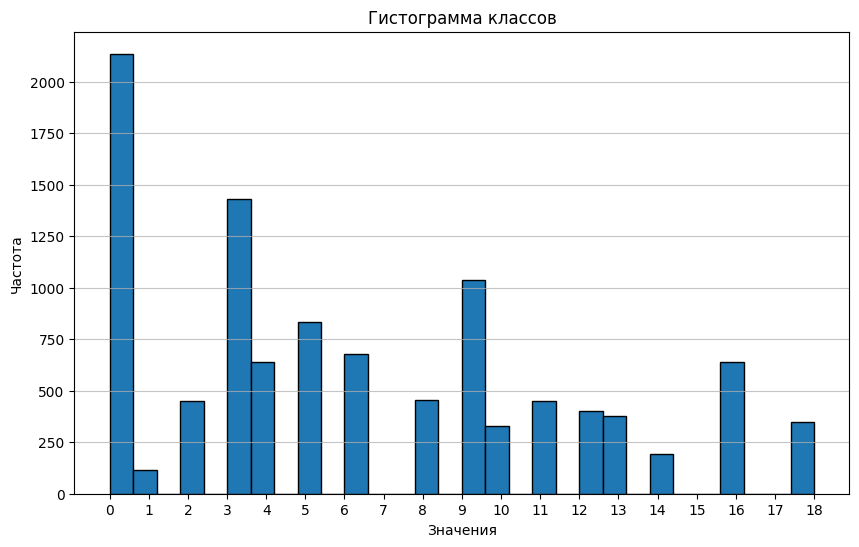

In [ ]:
plt.figure(figsize=(10, 6))
train_data['target_feature'].plot.hist(bins=30, edgecolor='black')

plt.xticks(range(int(data['target_feature'].min()), int(data['target_feature'].max()) + 1))

plt.title('Гистограмма классов')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

Аугментируем train выборку

In [ ]:
img_base = CustomDataset(train_data, "human_poses_data/img_train/", counts, [transformx, transformx1, transformx2, transformx3, transformx4, transformx5, transformx6, transformx7, transformx8])

Loading images: 100%|██████████| 10511/10511 [06:03<00:00, 28.91it/s]


Гистаграмма после аугментаций

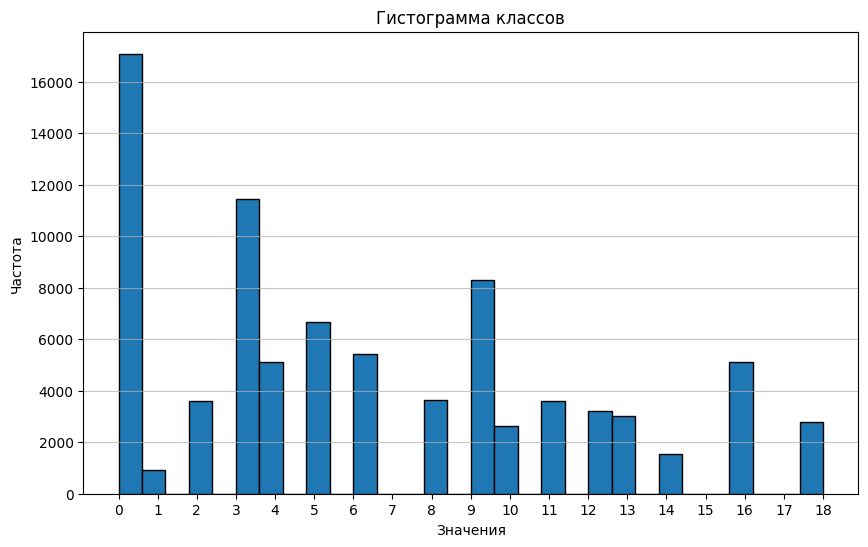

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(img_base.labels, bins=30, edgecolor='black')

plt.xticks(range(int(data['target_feature'].min()), int(data['target_feature'].max()) + 1))

plt.title('Гистограмма классов')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

Изначальный класс обработки датасета (не способен на адаптивную аугментацию)

In [ ]:
class CustomDataset2(torch.utils.data.Dataset):
    def __init__(self, data_frame, images_dir, transform=None):
        super().__init__()
        self.transform = transform
        self.data = []
        self.labels = []

        def load_image(row):
            img_path = f"{images_dir}{row['img_id']}.jpg"
            target = int(row['target_feature'])
            image = torchvision.io.read_image(img_path).float() / 255.0

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(target)

        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(load_image, row): row for _, row in data_frame.iterrows()}
            for future in tqdm(futures.keys(), desc='Loading images'):
                image, target = future.result()
                self.data.append(image)
                self.labels.append(target)

    def __len__(self):
        return len(self.data)

    def get_labels(self):
        return [label.item() for label in self.labels]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

Обработка Val датасета

In [ ]:
train_dataset = img_base
val_dataset = CustomDataset2(test_data, "human_poses_data/img_train/", transformx)

Loading images: 100%|██████████| 1856/1856 [00:05<00:00, 358.94it/s]


In [ ]:
BATCH_SIZE = 300

Создание load-еров

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                                           pin_memory=True)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

In [ ]:
torch.cuda.empty_cache()

# Обучение

In [ ]:
NUM_EPOCH = 50
trainer.train(train_loader, NUM_EPOCH, test_loader)

100%|██████████| 281/281 [01:19<00:00,  3.52it/s]


Epoch 1, Training Loss: 0.005364728962339623, Training Accuracy: 0.3322233850252117


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Model improved and saved.
Validation Loss: 1.600973197392055, Validation Accuracy: 0.3480603448275862


100%|██████████| 281/281 [01:13<00:00,  3.81it/s]


Epoch 2, Training Loss: 0.0037445053018735166, Training Accuracy: 0.48302968318904005


100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Model improved and saved.
Validation Loss: 1.2955340828214372, Validation Accuracy: 0.4552801724137931


100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 3, Training Loss: 0.0024896164059400806, Training Accuracy: 0.6243102464085244


100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


Model improved and saved.
Validation Loss: 1.0762282184192113, Validation Accuracy: 0.5382543103448276


100%|██████████| 281/281 [01:14<00:00,  3.80it/s]


Epoch 4, Training Loss: 0.0014918638008207454, Training Accuracy: 0.7488226619731709


100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


Model improved and saved.
Validation Loss: 1.0967773624828883, Validation Accuracy: 0.5705818965517241


100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 5, Training Loss: 0.0008233616458350069, Training Accuracy: 0.845447626296261


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]

Model improved and saved.


Validation Loss: 1.2111117499215263, Validation Accuracy: 0.5926724137931034


100%|██████████| 281/281 [01:13<00:00,  3.81it/s]


Epoch 6, Training Loss: 0.0005018068630797302, Training Accuracy: 0.8975121301493674


100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


Model improved and saved.
Validation Loss: 1.1665887492043632, Validation Accuracy: 0.6018318965517241


100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 7, Training Loss: 0.0003662487828574033, Training Accuracy: 0.9216891827609172


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Model improved and saved.
Validation Loss: 1.2253531643322535, Validation Accuracy: 0.6174568965517241


100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 8, Training Loss: 0.0002658027101082343, Training Accuracy: 0.9393968223765579


100%|██████████| 7/7 [00:14<00:00,  2.00s/it]

Model improved and saved.


Validation Loss: 1.251460782119206, Validation Accuracy: 0.6293103448275862


100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 9, Training Loss: 0.00023648644646521771, Training Accuracy: 0.9459138045856722


100%|██████████| 7/7 [00:13<00:00,  1.97s/it]

Model improved and saved.


Validation Loss: 1.286225174154554, Validation Accuracy: 0.6363146551724138


100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 10, Training Loss: 0.00019655785144216076, Training Accuracy: 0.9536913709447246


100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


Model improved and saved.
Validation Loss: 1.2708697319030762, Validation Accuracy: 0.6422413793103449


100%|██████████| 281/281 [01:13<00:00,  3.81it/s]


Epoch 11, Training Loss: 0.00019679662337626449, Training Accuracy: 0.953905432404148


100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


Улучшений не обнаружено, счетчик терпения 1/20
Validation Loss: 1.4547675507409232, Validation Accuracy: 0.6142241379310345


100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 12, Training Loss: 0.00019000622074550984, Training Accuracy: 0.9559865854818761


100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Улучшений не обнаружено, счетчик терпения 2/20
Validation Loss: 1.393451792853219, Validation Accuracy: 0.6201508620689655


100%|██████████| 281/281 [01:14<00:00,  3.80it/s]


Epoch 13, Training Loss: 0.00015893804801048696, Training Accuracy: 0.9629435829131386


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Model improved and saved.
Validation Loss: 1.2795893890517098, Validation Accuracy: 0.6492456896551724


100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 14, Training Loss: 0.0001365458224399008, Training Accuracy: 0.9669393968223765


100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


Улучшений не обнаружено, счетчик терпения 1/20
Validation Loss: 1.5280944279261999, Validation Accuracy: 0.609375


100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 15, Training Loss: 0.00016070016110315033, Training Accuracy: 0.96158786033679


100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Улучшений не обнаружено, счетчик терпения 2/20
Validation Loss: 1.4779235890933446, Validation Accuracy: 0.6379310344827587


100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 16, Training Loss: 0.00014249960592286113, Training Accuracy: 0.9655242127295215


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Model improved and saved.
Validation Loss: 1.3621769121715002, Validation Accuracy: 0.6535560344827587


100%|██████████| 281/281 [01:14<00:00,  3.78it/s]


Epoch 17, Training Loss: 0.00011906060603046854, Training Accuracy: 0.9717557796594044


100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Улучшений не обнаружено, счетчик терпения 1/20
Validation Loss: 1.3636535917009627, Validation Accuracy: 0.6379310344827587


100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 18, Training Loss: 0.00011432820692686423, Training Accuracy: 0.9721482256683475


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Улучшений не обнаружено, счетчик терпения 2/20
Validation Loss: 1.3788460663386755, Validation Accuracy: 0.6395474137931034


100%|██████████| 281/281 [01:14<00:00,  3.78it/s]


Epoch 19, Training Loss: 0.0001340344836389597, Training Accuracy: 0.9683307963086291


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Улучшений не обнаружено, счетчик терпения 3/20
Validation Loss: 1.472110961164747, Validation Accuracy: 0.6379310344827587


100%|██████████| 281/281 [01:14<00:00,  3.78it/s]


Epoch 20, Training Loss: 0.00012023553054011743, Training Accuracy: 0.9710779183712301


100%|██████████| 7/7 [00:14<00:00,  2.01s/it]


Model improved and saved.
Validation Loss: 1.335963683468955, Validation Accuracy: 0.6573275862068966


100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 21, Training Loss: 0.0001145841439629202, Training Accuracy: 0.9728855484730282


100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


Улучшений не обнаружено, счетчик терпения 1/20
Validation Loss: 1.4027246236801147, Validation Accuracy: 0.630926724137931


100%|██████████| 281/281 [01:13<00:00,  3.81it/s]


Epoch 22, Training Loss: 9.847747204138065e-05, Training Accuracy: 0.9750380553705642


100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


Улучшений не обнаружено, счетчик терпения 2/20
Validation Loss: 1.426860851900918, Validation Accuracy: 0.6438577586206896


100%|██████████| 281/281 [01:14<00:00,  3.77it/s]


Epoch 23, Training Loss: 8.10335083055581e-05, Training Accuracy: 0.9795571306250594


100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


Улучшений не обнаружено, счетчик терпения 3/20
Validation Loss: 1.4983519656317574, Validation Accuracy: 0.6320043103448276


100%|██████████| 281/281 [01:13<00:00,  3.81it/s]


Epoch 24, Training Loss: 0.00010724626635040458, Training Accuracy: 0.9736228712777091


100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


Улучшений не обнаружено, счетчик терпения 4/20
Validation Loss: 1.408279470035008, Validation Accuracy: 0.650323275862069


100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 25, Training Loss: 0.00011000225882255652, Training Accuracy: 0.9736942250975169


100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Model improved and saved.
Validation Loss: 1.434317605836051, Validation Accuracy: 0.6530172413793104


100%|██████████| 281/281 [01:14<00:00,  3.78it/s]


Epoch 26, Training Loss: 8.218039127040859e-05, Training Accuracy: 0.9795571306250594


100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


Epoch 00026: reducing learning rate of group 0 to 5.0000e-04.
Model improved and saved.
Validation Loss: 1.3581961052758353, Validation Accuracy: 0.6481681034482759


100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 27, Training Loss: 1.8215377184726592e-05, Training Accuracy: 0.9951836171629721


100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


Model improved and saved.
Validation Loss: 1.2930694818496704, Validation Accuracy: 0.6891163793103449


100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 28, Training Loss: 3.0949634303465217e-06, Training Accuracy: 0.9991675387689087


100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


Model improved and saved.
Validation Loss: 1.2575228640011378, Validation Accuracy: 0.6901939655172413


100%|██████████| 281/281 [01:14<00:00,  3.77it/s]


Epoch 29, Training Loss: 1.6139508515838808e-06, Training Accuracy: 0.9996075539910569


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Улучшений не обнаружено, счетчик терпения 1/20
Validation Loss: 1.2696221470832825, Validation Accuracy: 0.6837284482758621


100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 30, Training Loss: 1.0711272338273394e-06, Training Accuracy: 0.9997502616306726


100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


Model improved and saved.
Validation Loss: 1.2532473632267542, Validation Accuracy: 0.6901939655172413


100%|██████████| 281/281 [01:14<00:00,  3.80it/s]


Epoch 31, Training Loss: 1.094264955557348e-06, Training Accuracy: 0.9998216154504804


100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


Model improved and saved.
Validation Loss: 1.2473591140338354, Validation Accuracy: 0.6923491379310345


100%|██████████| 281/281 [01:14<00:00,  3.77it/s]


Epoch 32, Training Loss: 1.0586192219170494e-06, Training Accuracy: 0.9997026924174675


100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Model improved and saved.
Validation Loss: 1.2643856746809823, Validation Accuracy: 0.6901939655172413


100%|██████████| 281/281 [01:14<00:00,  3.75it/s]


Epoch 33, Training Loss: 4.453511195841562e-06, Training Accuracy: 0.9987275235467605


100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


Улучшений не обнаружено, счетчик терпения 1/20
Validation Loss: 1.2990732448441642, Validation Accuracy: 0.6761853448275862


100%|██████████| 281/281 [01:14<00:00,  3.78it/s]


Epoch 34, Training Loss: 1.2390427244349794e-05, Training Accuracy: 0.9967534011987442


100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


Улучшений не обнаружено, счетчик терпения 2/20
Validation Loss: 1.5841506208692278, Validation Accuracy: 0.6400862068965517


100%|██████████| 281/281 [01:14<00:00,  3.77it/s]


Epoch 35, Training Loss: 9.526079887184538e-05, Training Accuracy: 0.976167824184188


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Улучшений не обнаружено, счетчик терпения 3/20
Validation Loss: 1.3946749567985535, Validation Accuracy: 0.6734913793103449


100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 36, Training Loss: 2.5727844409634723e-05, Training Accuracy: 0.9932689563314623


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Улучшений не обнаружено, счетчик терпения 4/20
Validation Loss: 1.426595824105399, Validation Accuracy: 0.662176724137931


100%|██████████| 281/281 [01:14<00:00,  3.78it/s]


Epoch 37, Training Loss: 1.534562248301181e-05, Training Accuracy: 0.9960398630006659


100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


Epoch 00037: reducing learning rate of group 0 to 2.5000e-04.
Улучшений не обнаружено, счетчик терпения 5/20
Validation Loss: 1.4077669382095337, Validation Accuracy: 0.677801724137931


100%|██████████| 281/281 [01:13<00:00,  3.81it/s]


Epoch 38, Training Loss: 4.014447025879495e-06, Training Accuracy: 0.9988940157929788


100%|██████████| 7/7 [00:13<00:00,  1.98s/it]

Model improved and saved.


Validation Loss: 1.3213742630822318, Validation Accuracy: 0.6896551724137931


100%|██████████| 281/281 [01:13<00:00,  3.81it/s]


Epoch 39, Training Loss: 1.1121491865273394e-06, Training Accuracy: 0.9997383693273714


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]

Model improved and saved.


Validation Loss: 1.3290532401629858, Validation Accuracy: 0.6945043103448276


100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 40, Training Loss: 8.390127269592578e-07, Training Accuracy: 0.9996908001141661


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Model improved and saved.
Validation Loss: 1.3257375529834203, Validation Accuracy: 0.693426724137931


100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 41, Training Loss: 8.629708955227731e-07, Training Accuracy: 0.99972647702407


100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Model improved and saved.
Validation Loss: 1.3279753242220198, Validation Accuracy: 0.6950431034482759


100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 42, Training Loss: 4.2702775965211505e-07, Training Accuracy: 0.9998572923603843


100%|██████████| 7/7 [00:13<00:00,  1.99s/it]

Model improved and saved.


Validation Loss: 1.3276442800249373, Validation Accuracy: 0.6977370689655172


100%|██████████| 281/281 [01:13<00:00,  3.81it/s]


Epoch 43, Training Loss: 4.274677433810547e-07, Training Accuracy: 0.9998929692702883


100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


Model improved and saved.
Validation Loss: 1.344116985797882, Validation Accuracy: 0.6955818965517241


100%|██████████| 281/281 [01:13<00:00,  3.81it/s]


Epoch 44, Training Loss: 5.942298316617937e-07, Training Accuracy: 0.9998572923603843


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Model improved and saved.
Validation Loss: 1.3594207678522383, Validation Accuracy: 0.6950431034482759


100%|██████████| 281/281 [01:14<00:00,  3.80it/s]


Epoch 45, Training Loss: 5.867708013076914e-07, Training Accuracy: 0.9997621539339739


100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


Model improved and saved.
Validation Loss: 1.3335337894303458, Validation Accuracy: 0.6988146551724138


100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 46, Training Loss: 3.912596065464125e-07, Training Accuracy: 0.9998691846636857


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Улучшений не обнаружено, счетчик терпения 1/20
Validation Loss: 1.3362805162157332, Validation Accuracy: 0.693426724137931


100%|██████████| 281/281 [01:13<00:00,  3.81it/s]


Epoch 47, Training Loss: 5.444355114373879e-07, Training Accuracy: 0.9998335077537818


100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


Model improved and saved.
Validation Loss: 1.349464041846139, Validation Accuracy: 0.6945043103448276


100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 48, Training Loss: 5.797326292029272e-07, Training Accuracy: 0.9998454000570831


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Model improved and saved.
Validation Loss: 1.3602440527507238, Validation Accuracy: 0.6918103448275862


100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 49, Training Loss: 4.5591468309902684e-07, Training Accuracy: 0.9998810769669869


100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


Model improved and saved.
Validation Loss: 1.3439319389207023, Validation Accuracy: 0.6939655172413793


100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 50, Training Loss: 3.220443370277163e-07, Training Accuracy: 0.9998810769669869


100%|██████████| 7/7 [00:13<00:00,  1.95s/it]

Model improved and saved.
Validation Loss: 1.3450254883084978, Validation Accuracy: 0.6977370689655172


# Графики

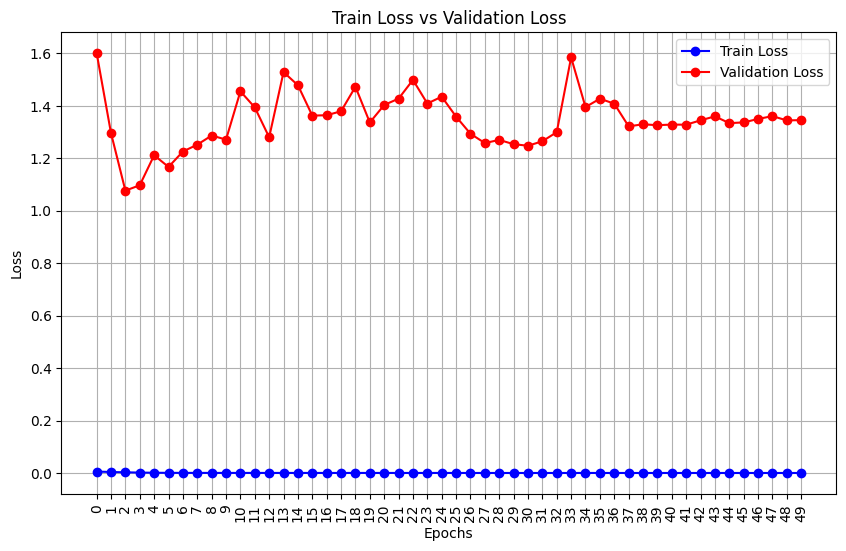

In [ ]:
import numpy as np

plt.figure(figsize=(10, 6))

plt.plot(np.arange(50), trainer.train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(np.arange(50), trainer.val_losses, label='Validation Loss', color='red', marker='o')

plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(50))
plt.grid(True)

plt.legend()
plt.xticks(np.arange(50), rotation=90)
plt.show()

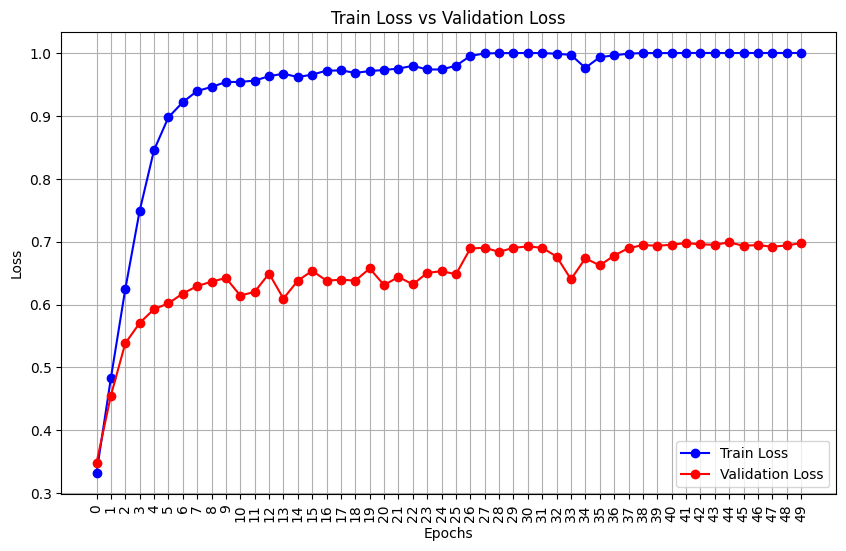

In [ ]:
import numpy as np

plt.figure(figsize=(10, 6))

plt.plot(np.arange(50), trainer.train_accuracies, label='Train Loss', color='blue', marker='o')
plt.plot(np.arange(50), trainer.val_accuracies, label='Validation Loss', color='red', marker='o')

plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(50))
plt.grid(True)

plt.legend()
plt.xticks(np.arange(50), rotation=90)
plt.show()

In [ ]:
# PATH = "mobileV2.pt"
# print('Model improved and saved.')
# torch.save(trainer.model.state_dict(), PATH)